# A/B Testing Fast FoodMarketing Campaign

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.


# Introduction

In this notebook I will analyze the data and decide which promotion has the greatest effect on sales.

## Data Set

I will be using data from kagglehub [IBM Watson Analytics Marketing Campaign](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test). This data is created from real data from a fast-food chain.

## Goal

Which promotion strategy works the best?


## Biases

I did not find any biases in the data.

## Domain knowledge

I am not a marketing expert, but I have a good understanding of statistics which I will use to analyze the data and make decisions.


## Libraries

In [1]:
import warnings
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
from scipy.stats import chi2_contingency, levene, mannwhitneyu, shapiro, ttest_ind

warnings.filterwarnings("ignore")

/root/Turing_College/project_reviews/my_projects/jusvyka-DS.v3.2.2.5/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data

In [2]:
raw_df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "chebotinaa/fast-food-marketing-campaign-ab-test",
    "WA_Marketing-Campaign.csv",
)
Path("data").mkdir(parents=True, exist_ok=True)
raw_df.to_csv("data/raw_market_campaign.csv", index=False)

## Display parameters

In [3]:
pal = dict(zip(raw_df["Promotion"].unique(), sns.color_palette("magma", n_colors=3), strict=False))
pal_strings = dict(
    zip(
        [str(x) for x in raw_df["Promotion"].unique()],
        sns.color_palette("magma", n_colors=3),
        strict=False,
    )
)

## Data overview

Columns:
- MarketID: unique identifier for market
- MarketSize: size of market area by sales
- LocationID: unique identifier for store location
- AgeOfStore: age of store in years
- Promotion: one of three promotions that were tested
- week: one of four weeks when the promotions were run
- SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [4]:
raw_df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


Notice that there are 10 different markets with 137 different store locations. The markets are distributed across 3 different market sizes. 3 different promotions have been run for 4 weeks. This can be seen from below.

In [5]:
print("\nUnique values for categorical variables:")
print("MarketID unique values:", raw_df["MarketID"].nunique())
print("MarketSize unique values:", raw_df["MarketSize"].unique())
print("LocationID unique values:", raw_df["LocationID"].nunique())
print("Promotion unique values:", raw_df["Promotion"].unique())
print("Week unique values:", raw_df["week"].unique())



Unique values for categorical variables:
MarketID unique values: 10
MarketSize unique values: ['Medium' 'Small' 'Large']
LocationID unique values: 137
Promotion unique values: [3 2 1]
Week unique values: [1 2 3 4]


Market sizes are balanced across promotions overall as seen below.

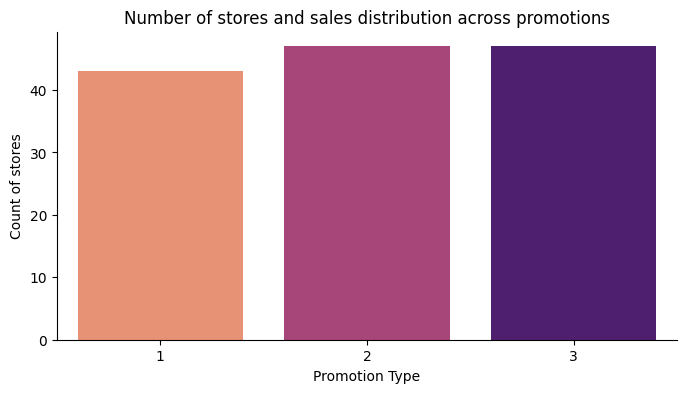

In [6]:
week1_df = raw_df[raw_df["week"] == 1]
fig, ax1 = plt.subplots(figsize=(8,4))
sns.barplot(data=week1_df.groupby(by="Promotion")["LocationID"].size().reset_index(name="count"),
            x="Promotion", y="count", ax=ax1, palette=pal_strings)
ax1.set_xlabel("Promotion Type")
ax1.set_ylabel("Count of stores")
ax1.tick_params(axis="y")

plt.title("Number of stores and sales distribution across promotions")
sns.despine()

Notice how above promotion 3 works better for large markets. But overall it is better to use 1st promotion as seen from graph below.

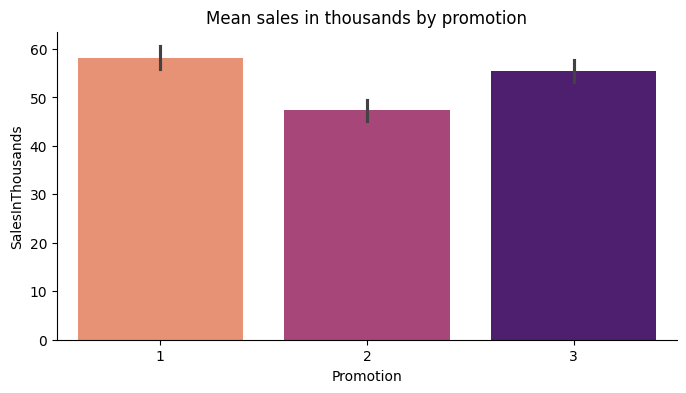

In [7]:
plt.figure(figsize=(8, 4))
sns.barplot(data=raw_df, x="Promotion", y="SalesInThousands", palette=pal_strings)
plt.title("Mean sales in thousands by promotion")
sns.despine()


Below is the distribution of store ages. Notice how most of stores are less than 15 years old. There might be a good idea to check how promotions work in older stores, as they might be more loyal to the brand and care less about new promotions.

Text(0.5, 1.0, 'Store Ages Distribution')

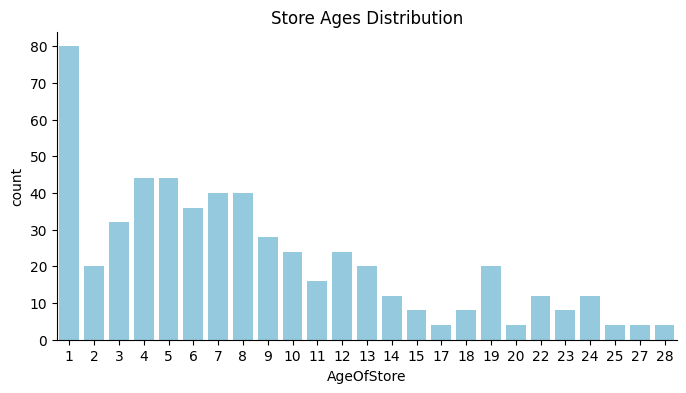

In [8]:
ages_df = (
    raw_df.groupby(by=["AgeOfStore"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .sort_values(by="AgeOfStore")
)
plt.figure(figsize=(8,4))
sns.barplot(x=ages_df["AgeOfStore"], y=ages_df["count"], color="skyblue")
sns.despine()
plt.title("Store Ages Distribution")

As you can see from above market 2 doesnt have promotions number 2 at all so we cant compare much and also there 5 times more stores having promotion 3 than 1. I will check whether market sizes are balanced across promotions in analysis part. Below notice how promotions are distributed across market sizes.

Text(0.5, 1.0, 'Mean sales in thousands by market size and promotion')

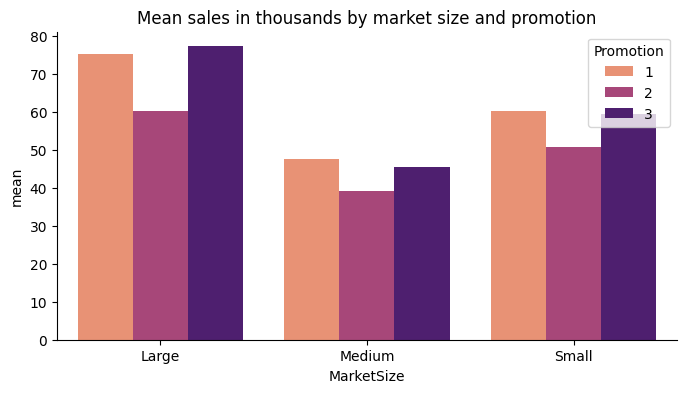

In [9]:
market_size_df = (
    raw_df.groupby(["MarketSize", "Promotion"])["SalesInThousands"].mean().reset_index(name="mean")
)
plt.figure(figsize=(8, 4))
sns.barplot(market_size_df, x="MarketSize", y="mean", hue="Promotion", palette=pal)
sns.despine()
plt.legend(title="Promotion", loc="upper right")
plt.title("Mean sales in thousands by market size and promotion")


Below is the distribution of promotions across 10 different markets. Notice how market 2 doesnt have a promotion 2 at all so we cant compare much and also there 5 times more stores having promotion 3 than 1. I will check whether market sizes are balanced across promotions in analysis part.

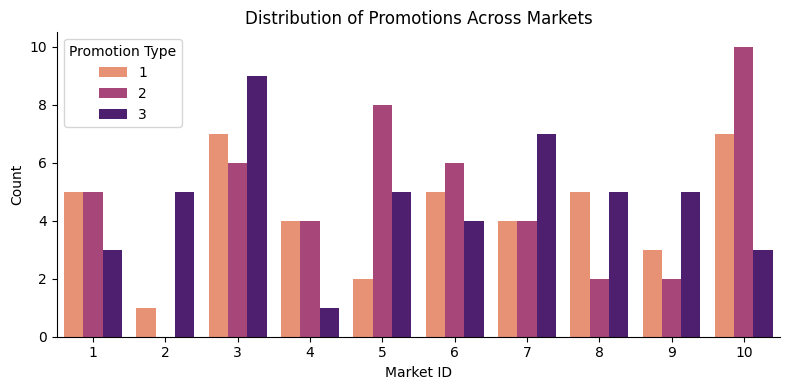

In [10]:
market_id_df = (
    week1_df.groupby(by=["Promotion", "MarketID", "MarketSize"])["MarketID"]
    .size()
    .reset_index(name="count")
)
plt.figure(figsize=(8,4))
sns.barplot(data=market_id_df, x="MarketID", y="count", hue="Promotion", palette=pal)
sns.despine()
plt.title("Distribution of Promotions Across Markets")
plt.xlabel("Market ID")
plt.ylabel("Count")
plt.legend(title="Promotion Type")
plt.tight_layout()

Notice from graph below that market 3 has 20 thousand more sales on average in each promotion than other markets. This might be an outlier which might skew the results.

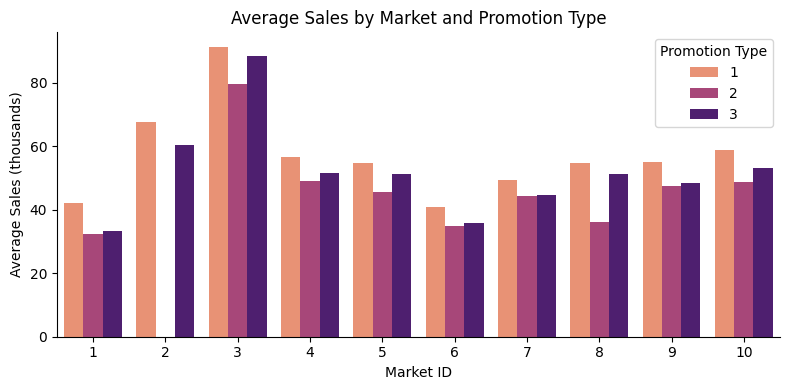

In [11]:

market_id_df = (
    week1_df.groupby(by=["Promotion", "MarketID", "MarketSize"])["SalesInThousands"]
    .mean()
    .reset_index(name="mean")
)
plt.figure(figsize=(8, 4))
sns.barplot(data=market_id_df, x="MarketID", y="mean", hue="Promotion", palette=pal)
sns.despine()
plt.title("Average Sales by Market and Promotion Type")
plt.xlabel("Market ID")
plt.ylabel("Average Sales (thousands)")
plt.legend(title="Promotion Type")
plt.tight_layout()


# Data Preprocessing

First I will prepeare the data for analysis by cleaning data:
- check data types
- check nulls
- check for duplicate rows and collumns
- check outlier values

All types of data are correct as seen below.

In [12]:
raw_df.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

No missing or duplicate rows as seen below.

In [13]:
print("\nMissing values:")
print(raw_df.isna().sum())
print("\nDuplicate rows:", raw_df.duplicated().sum())


Missing values:
MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

Duplicate rows: 0


Outliers can be seen from boxplot below. Altough I will not remove them as they are not extreme and probably is valid data.

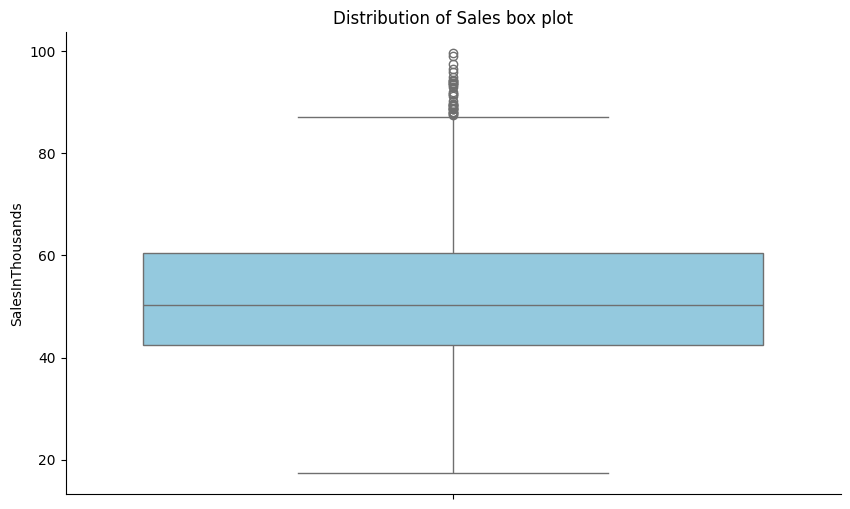

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=raw_df, y="SalesInThousands", color="skyblue")
plt.title("Distribution of Sales box plot")
sns.despine()
plt.show()


I will double check that outliers are not extreme and indeed they seem to be valid data as seen below.

In [15]:
raw_df.sort_values("SalesInThousands", ascending=False).head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
144,3,Large,218,2,1,1,99.65
154,3,Large,220,3,1,3,99.12
111,3,Large,209,1,1,4,97.61
104,3,Large,208,1,3,1,96.48
109,3,Large,209,1,1,2,96.01


# Design of experiment

As the experiment was not designed by me and is based on pre-existing Kaggle data, I will be making some assumptions in design:

- Subject of experiment is LocationID corresponding to each store
- Invariant metrics are count of market sizes and market id's
- My evaluation metric will be SalesInThousands
- When designing the experimetn it is important to decide on duration of experiment, and the amount of flow used for experiment. In description of data I find that duration of experiment is 4 weeks while I cannot say anything of how of the flow was used but this is unimportant for our goal.
- I assume that sample size is enough to detect effect size of 2 thousands with statistical significance 0.05 and statistical power 0.8

# Analysing experiment

Things I will do in this section:
- Test whether data is balanced across promotions.
- Test which promotion is statistically better overall. This includes checking for chosen tests assumptions.
- Test which promotion is statistically better in different market sizes. This includes checking assumptions as well.

## Test whether data is balanced across promotions

It is important to check whether data is balanced across promotions as if it is not this might introduce bias towards one of the promotions. 

I have checked that data is indeed balanced across markets and market sizes which can be seen from cells below

### Balance across markets

- **Null hypothesis**: Markets (MarketID) are balanced across promotions
- **Alternative hypothesis**: Markets (MarketID) are not balanced across promotions

I will use chi-squared test to check whether MarketID is balanced across promotions with significance level 0.05. This means that if p-value is less than 0.05 I will reject the null hypothesis with 95% confidence that I made the right decision.

after running the test p-value is greater than 0.05 thus stay with Null hypothesis

In [16]:
week_1_df = raw_df[raw_df["week"] == 1]

contingency_table = pd.crosstab(week_1_df["MarketID"], week_1_df["Promotion"])
_, p_market_id, _, _ = chi2_contingency(contingency_table)
print(f"p-value: {p_market_id:.4f}")
if p_market_id < 0.05:  # noqa: PLR2004
    print("p-value is less than 0.05 reject Null hypothesis")
else:
    print("p-value is greater than 0.05 thus stay with Null hypothesis")

p-value: 0.2559
p-value is greater than 0.05 thus stay with Null hypothesis


### Balance across market sizes

- **Null hypothesis**: Markets sizes (MarketSize) are balanced across promotions
- **Alternative hypothesis**: Markets sizes (MarketSize) are not balanced across promotions

I will use chi-squared test to check whether MarketSize is balanced across promotions with significance level 0.05. This means that if p-value is less than 0.05 I will reject the null hypothesis with 95% confidence that I made the right decision.

after running the test p-value is greater than 0.05 thus stay with Null hypothesis

In [17]:
market_size_promo = pd.crosstab(week_1_df["MarketSize"], week_1_df["Promotion"])
_, p_market_size, _, _ = chi2_contingency(market_size_promo)
print(f"p-value: {p_market_size:.4f}")
if p_market_size < 0.05:  # noqa: PLR2004
    print("p-value is less than 0.05 reject Null hypothesis")
else:
    print("p-value is greater than 0.05 thus stay with Null hypothesis")

p-value: 0.8800
p-value is greater than 0.05 thus stay with Null hypothesis


## Test evaluation metric SalesInThousands

I will test overall which promotion is best. As more robust methods assume normality of data then I will split data by market size in hope of finding normal distribution and test again. Another reason for this is that insight might give nuanced recommendations instead of a one-size-fits-all strategy.

- The results from overall test is that promotion 1 is best with 95% confidence.
- While from segmented data tests I find that promotion 1 is significantly better than 2 and 3 in medium markets and have 95% confidence that my decision is correct. While for small and large markets promotion 1 is statistically similar to 3, however mean sales in small markets are higher with promotion 1 while larger markets are higher with promotion 3.

Thus I recommend using promotion 1 in small and medium markets and promotion 3 in large markets.


### Test promotions overall

There is 3 promotions and I will test each of them against each other which means I will test 3 combinations. Each combination has following hypotheses:

- **Null hypothesis**: 2 of selected promotions are equal
- **Alternative hypothesis**: 2 of selected promotions are not equal

I will test using U-test to check whether promotions are equal with significance level 0.05. This means that if p-value is less than 0.05 I will reject the null hypothesis with 95% confidence that I made the right decision.

after running the test I find that 1st promotion is better than 2 and 3. 

##### Distribution of data

More robust methods assume normality of data thus I will check whether data is normally distributed.

After checking I find that data is not normally distributed thus I will use U-test which does not assume normality.

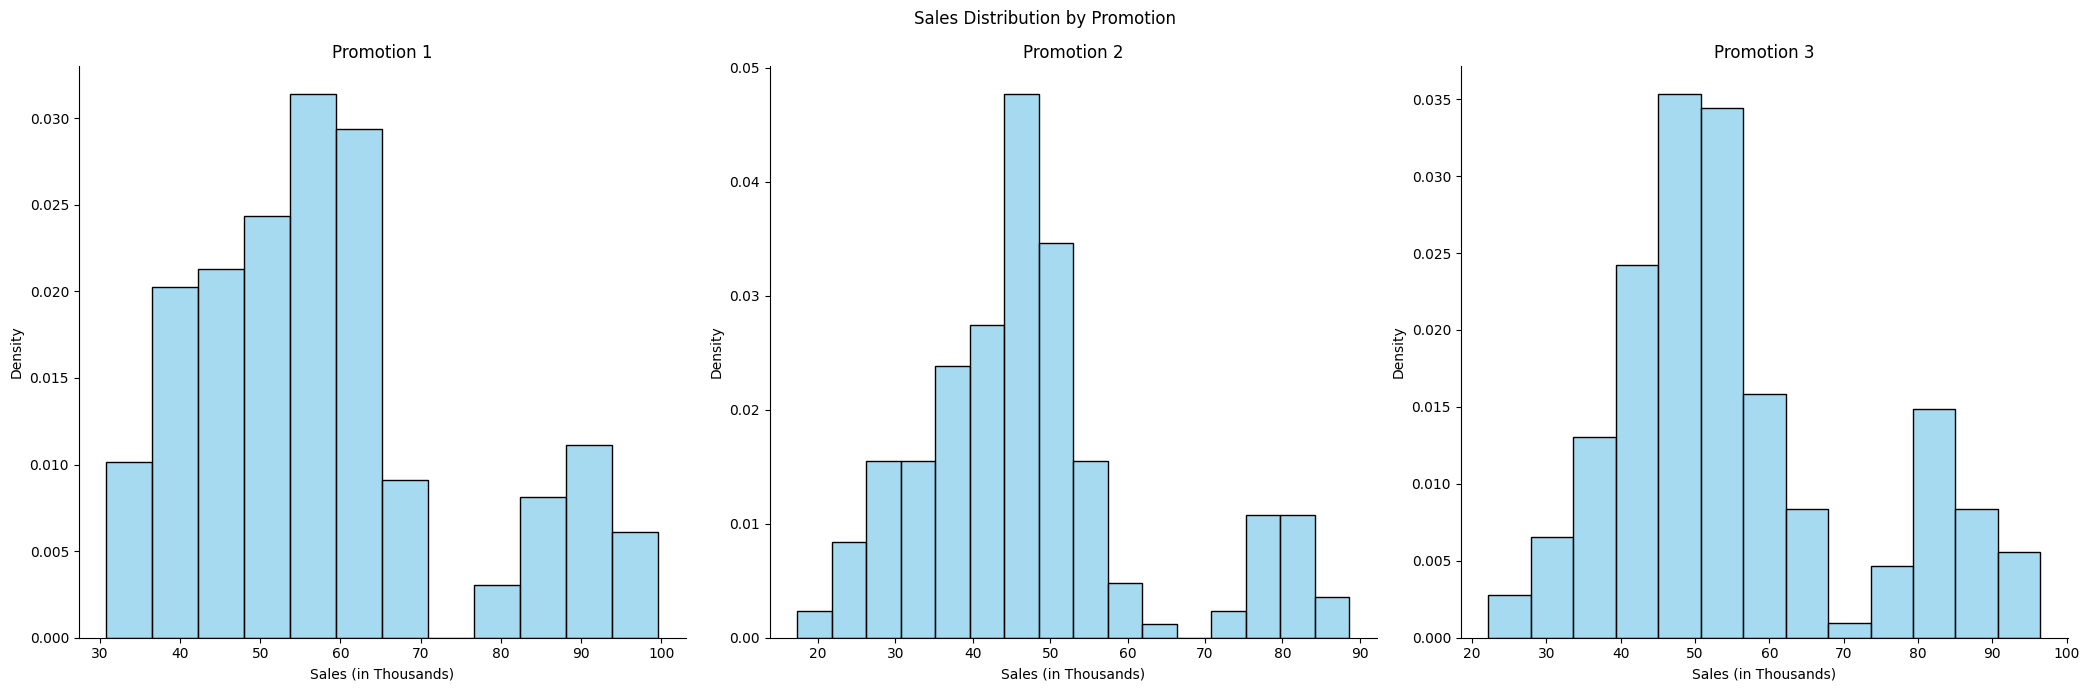

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle("Sales Distribution by Promotion")

for i, promo in enumerate([1, 2, 3]):
    sns.histplot(
        data=raw_df[raw_df["Promotion"] == promo],
        x="SalesInThousands",
        multiple="layer",
        stat="density",
        ax=axes[i],
        color="skyblue"
    )
    axes[i].set_title(f"Promotion {promo}")
    axes[i].set_xlabel("Sales (in Thousands)")
    axes[i].set_ylabel("Density")
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()


I find that visually the data does not look normal distributed. Also notice from the distributions above is indication that if I split data by Market size I would get normal distribution as the right tail seems to correspond to large markets. 

Lets check normality statistically.

- **Null hypothesis**: the data is normally distributed
- **Alternative hypothesis**: the data is not normally distributed

I will test using shapiro-wilk test to check whether data is normally distributed with significance level 0.05. This means that if p-value is less than 0.05 I will reject the null hypothesis with 95% confidence that I made the right decision.

From the test I find that all promotions are not normally distributed.

In [19]:
for promo in raw_df["Promotion"].unique():
    sales = raw_df[raw_df["Promotion"] == promo]["SalesInThousands"]
    stat, p_value = shapiro(sales)
    print(f"Shapiro-Wilk test for Promotion {promo}: p-value = {p_value:.4f}")
    if p_value < 0.05:  # noqa: PLR2004
        print(f"  Data for Promotion {promo} is not normally distributed")
    else:
        print(f"  Data for Promotion {promo} is normally distributed")


Shapiro-Wilk test for Promotion 3: p-value = 0.0000
  Data for Promotion 3 is not normally distributed
Shapiro-Wilk test for Promotion 2: p-value = 0.0000
  Data for Promotion 2 is not normally distributed
Shapiro-Wilk test for Promotion 1: p-value = 0.0000
  Data for Promotion 1 is not normally distributed


##### Test the difference between promotions

From the test below I find that promotion 1 is better than 2 and 3 with 95% confidence.

In [20]:
promotions = raw_df["Promotion"].unique()

for i in range(len(promotions)):
    for j in range(i + 1, len(promotions)):
        sales1 = raw_df[raw_df["Promotion"] == promotions[i]]["SalesInThousands"]
        sales2 = raw_df[raw_df["Promotion"] == promotions[j]]["SalesInThousands"]

        u_stat, p_val = mannwhitneyu(sales1, sales2, alternative="two-sided")

        print(f"-------------- u-test {promotions[i]} vs {promotions[j]} --------------")
        print(f"Mean {promotions[i]}: {sales1.mean():.2f
                                         }, Mean {promotions[j]}: {sales2.mean():.2f}")
        print(f"u-statistic = {u_stat:.4f}")
        print(f"p-value = {p_val:.4f}")
        print(f"{'Reject Null hypothesis' if p_val < 0.05 else 'Stay with Null hypothesis'}")  # noqa: PLR2004
        print()


-------------- u-test 3 vs 2 --------------
Mean 3: 55.36, Mean 2: 47.33
u-statistic = 23251.0000
p-value = 0.0000
Reject Null hypothesis

-------------- u-test 3 vs 1 --------------
Mean 3: 55.36, Mean 1: 58.10
u-statistic = 14089.0000
p-value = 0.0351
Reject Null hypothesis

-------------- u-test 2 vs 1 --------------
Mean 2: 47.33, Mean 1: 58.10
u-statistic = 9378.5000
p-value = 0.0000
Reject Null hypothesis



### Test promotions accross market sizes

I will be using t-test to test whether promotions are equal across small and medium markets as I found that they are normally distributed. While I will use U-test for large markets as they are not normally distributed. Note I will only look at 1st and 3rd promotion as 2nd promotion is far worse in mean sales.

- **Null hypothesis**: 1st promotion is equal to 3rd promotion across specific market size
- **Alternative hypothesis**: 1st promotion is not equal to 3rd promotion across specific market size

After running the test I find 1st promotion is better than 3rd promotion in medium markets.

#### Assumptions

To use t-test I need to check the following assumptions:
- Normality -> We can do the test on small and medium markets as they are normally distributed, while for large markets I will use U-test for final decision.
- Homogeneity of variances -> The variances across small and medium markets are similar, this I show using Levene's test in following cells
- Independence of samples -> As the data is randomised, this assumption is satisfied.

##### Normality
I will check normality for normal distribution first using shapiro-wilk test.

- **Null hypothesis**: the data is normally distributed
- **Alternative hypothesis**: the data is not normally distributed

I find that small and medium markets are normally distributed as their p-values are greater than 0.05, thus normal distribution assumption is satisfied. This can be seen below. Also notice that visually the data look normally distributed in those markets.

In [21]:
def plot_sales_distributions(raw_df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(2, 3, figsize=(21, 14))
    fig.suptitle("Sales Distribution by Promotion and Market Size")

    market_sizes = ["Small", "Medium", "Large"]

    for row, promo in enumerate([1, 3]):
        for col, size in enumerate(market_sizes):
            subset = raw_df[(raw_df["Promotion"] == promo) & (raw_df["MarketSize"] == size)]

            sns.histplot(
                data=subset, x="SalesInThousands",
                multiple="layer", stat="density", ax=axes[row, col]
            )
            _, p_value = shapiro(subset["SalesInThousands"])

            axes[row, col].set_title(
                f"Promotion {promo} - {size} Market\n"
                f"Shapiro-Wilk p={p_value:.4f}\n"
                f"{'Normal' if p_value > 0.05 else 'Not normal'}"  # noqa: PLR2004
            )
            axes[row, col].set_xlabel("Sales (in Thousands)")
            axes[row, col].set_ylabel("Density")
            sns.despine(ax=axes[row, col])

    plt.tight_layout()
    plt.show()

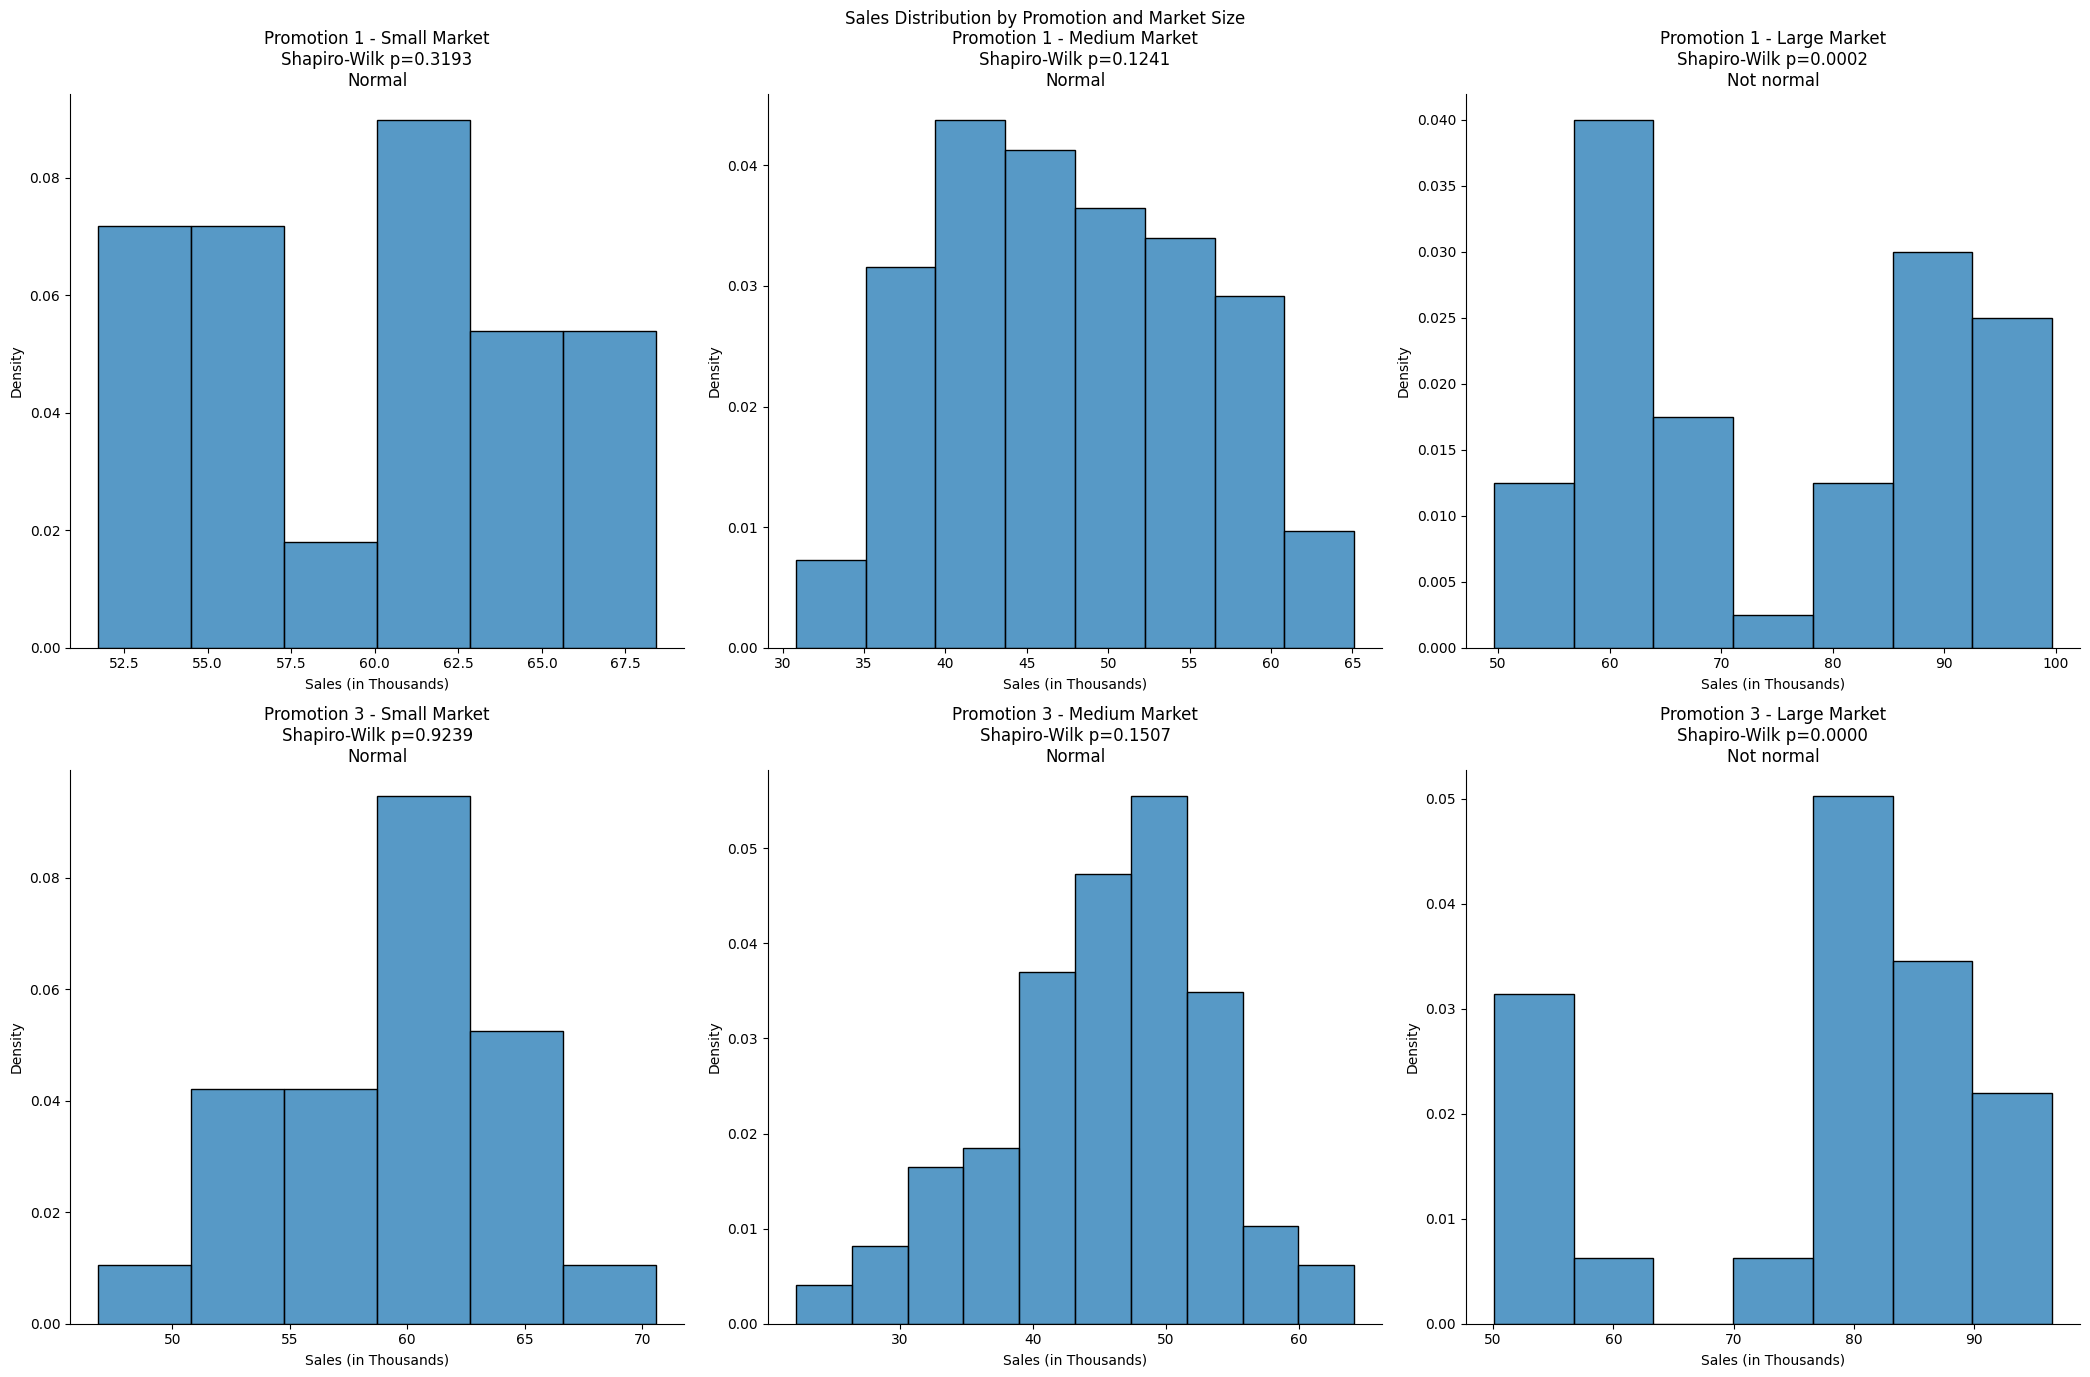

In [22]:
plot_sales_distributions(raw_df)

##### Homogeneity of variances

I will check whether variances are similar across small and medium markets using Levene's test.

- **Null hypothesis**: the variances are similar
- **Alternative hypothesis**: the variances are not similar

I find that variances are similar across small and medium markets as their p-values are greater than 0.05, thus similar variances assumption is satisfied. This can be seen below.

In [23]:
print("\nTests by market size:")
for size in ["Small", "Medium", "Large"]:
    df_subset = raw_df[raw_df["MarketSize"] == size]
    groups = [df_subset[df_subset["Promotion"] == p]["SalesInThousands"] for p in promotions]
    stat, p_value = levene(*groups)
    print(f"\n{size} Markets:")
    print(f"Levene statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print("Conclusion: " + ("Equal variances" if p_value > 0.05 else "Unequal variances"))  # noqa: PLR2004


Tests by market size:

Small Markets:
Levene statistic: 0.0636
p-value: 0.9384
Conclusion: Equal variances

Medium Markets:
Levene statistic: 0.8597
p-value: 0.4243
Conclusion: Equal variances

Large Markets:
Levene statistic: 2.1947
p-value: 0.1146
Conclusion: Equal variances


#### Test by market size

Here I will rewrite previously constructed hypothesis and test it in following cells.
- **Null hypothesis**: 1st promotion is equal to 3rd promotion across specific market size
- **Alternative hypothesis**: 1st promotion is not equal to 3rd promotion across specific market size

After doing the tests I find promotion 1 is statistically better than promotion 3 in medium market.

Not from below that there is no statistical difference between promotions in small sized markets.

In [24]:
small_markets = raw_df[(raw_df["MarketSize"] == "Small") & (raw_df["Promotion"].isin([1, 3]))]

promo1 = small_markets[small_markets["Promotion"] == 1]["SalesInThousands"]
promo3 = small_markets[small_markets["Promotion"] == 3]["SalesInThousands"]  # noqa: PLR2004

t_stat, p_value = ttest_ind(promo1, promo3, equal_var=True)

mean_promo1 = promo1.mean()
mean_promo3 = promo3.mean()
ci_promo1 = 1.96 * promo1.std() / np.sqrt(len(promo1))
ci_promo3 = 1.96 * promo3.std() / np.sqrt(len(promo3))

print("-----------------t-test Small Market-------------------")
print(f"\nPromotion 1 Mean: {mean_promo1:.2f} ± {ci_promo1:.2f}")
print(f"Promotion 3 Mean: {mean_promo3:.2f} ± {ci_promo3:.2f}")

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'}")  # noqa: PLR2004


-----------------t-test Small Market-------------------

Promotion 1 Mean: 60.16 ± 2.25
Promotion 3 Mean: 59.51 ± 2.09
T-statistic: 0.4139
P-value: 0.6811
Conclusion: No significant difference


Notice from below there is significant difference between promotions in medium markets

In [25]:
medium_markets = raw_df[(raw_df["MarketSize"] == "Medium") & (raw_df["Promotion"].isin([1, 3]))]

promo1 = medium_markets[medium_markets["Promotion"] == 1]["SalesInThousands"]
promo3 = medium_markets[medium_markets["Promotion"] == 3]["SalesInThousands"]  # noqa: PLR2004

t_stat, p_value = ttest_ind(promo1, promo3, equal_var=True)

mean_promo1 = promo1.mean()
mean_promo3 = promo3.mean()
ci_promo1 = 1.96 * promo1.std() / np.sqrt(len(promo1))
ci_promo3 = 1.96 * promo3.std() / np.sqrt(len(promo3))

print("-----------------t-test Medium Market-------------------")
print(f"\nPromotion 1 Mean: {mean_promo1:.2f} ± {ci_promo1:.2f}")
print(f"Promotion 3 Mean: {mean_promo3:.2f} ± {ci_promo3:.2f}")

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'}")  # noqa: PLR2004


-----------------t-test Medium Market-------------------

Promotion 1 Mean: 47.67 ± 1.61
Promotion 3 Mean: 45.47 ± 1.47
T-statistic: 1.9766
P-value: 0.0494
Conclusion: Significant difference


Notice below using u-test there is no significant difference between promotions in large markets.

In [26]:
large_markets = raw_df[(raw_df["MarketSize"] == "Large") & (raw_df["Promotion"].isin([1, 3]))]

promo1 = large_markets[large_markets["Promotion"] == 1]["SalesInThousands"]
promo3 = large_markets[large_markets["Promotion"] == 3]["SalesInThousands"]  # noqa: PLR2004

u_stat, p_value = mannwhitneyu(promo1, promo3, alternative="two-sided")

mean_promo1 = promo1.mean()
mean_promo3 = promo3.mean()
ci_promo1 = 1.96 * promo1.std() / np.sqrt(len(promo1))
ci_promo3 = 1.96 * promo3.std() / np.sqrt(len(promo3))

print("-----------------u-test Large Market-------------------")
print(f"\nPromotion 1 Mean: {mean_promo1:.2f} ± {ci_promo1:.2f}")
print(f"Promotion 3 Mean: {mean_promo3:.2f} ± {ci_promo3:.2f}")

print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'}")  # noqa: PLR2004

-----------------u-test Large Market-------------------

Promotion 1 Mean: 75.24 ± 4.06
Promotion 3 Mean: 77.20 ± 4.07
U-statistic: 1349.0000
P-value: 0.9766
Conclusion: No significant difference


Using promotion 1 than 3 is borderline statistically better in medium markets, while neither is statistically better than the other in small and large markets.

Nevertheless sales on average are better with promotion 1 and sales in large markets are better with promotion 3. Note this is not statistically significant thus might be due to chance. 

Nevertheless I recommend 1st promotion in small and medium markets and 3rd promotion in large markets.

# Conclusions

1. **Overall Performance**: Promotions 1 and 3 significantly outperformed Promotion 2. There was no statistically significant difference between Promotions 1 and 3 when looking at all markets combined.

2. **Performance by Market Size**:
   - **Large Markets**: Promotion 3 performed better (77.20 vs 75.24 thousand in sales), though not statistically significant.
   - **Medium Markets**: Promotion 1 performed significantly better (47.67 vs 45.47 thousand in sales)
   - **Small Markets**: Promotion 1 slightly outperformed Promotion 3 (60.16 vs 59.51 thousand in sales), but not statistically significant.

## Recommendations

Based on the statistical analysis:

1. **Eliminate Promotion 2** entirely as it underperformed across all market segments.

2. **Implement targeted approach**:
   - Use Promotion 1 for small and medium markets
   - Use Promotion 3 for large markets

3. **Alternative simple approach**: If implementation complexity is a concern, either Promotion 1 or 3 could be used across all markets with similar overall results, though you would sacrifice some performance optimization.

The targeted approach leverages the statistically significant advantage of Promotion 1 in medium markets while also taking advantage of the observed (though not statistically significant) benefits of Promotion 3 in large markets.
